<a href="https://colab.research.google.com/github/Alfredsamson/Ovarine_cancer_detection_Using_Deep_learning/blob/main/janet_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd

# Define image size, batch size, channels, and epochs
IMAGE_SIZE = (256,256)# Image dimensions
BATCH_SIZE = 32  # Number of images to process at once
CHANNELS = 3 # Number of color channels (RGB)
EPOCHES= 100  # Number of training iterations

# Import EarlyStopping for early stopping of training
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load image dataset from directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Computer_Vision",  # Path to image directory
    shuffle=True,  # Shuffle the dataset
    image_size=IMAGE_SIZE, # Resize images to specified size
    batch_size=BATCH_SIZE # Set batch size
)


Found 577 files belonging to 2 classes.


In [ ]:
# Import os and glob libraries

import os
import glob as gb
# Define path to image directory

path = "/content/drive/MyDrive/Computer_Vision"
size=[] # Initialize an empty list to store image sizes
# Iterate through folders and files to get image sizes

for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)

# Print the value counts of image sizes
pd.Series(size).value_counts()


,count
"(588, 1344, 3)",461
"(888, 1898, 3)",102
"(888, 1545, 3)",6
"(588, 808, 3)",5
"(588, 1024, 3)",3


In [ ]:
# Get class names from the dataset

class_names = dataset.class_names
class_names

['Complex cyst', 'Simple cyst']

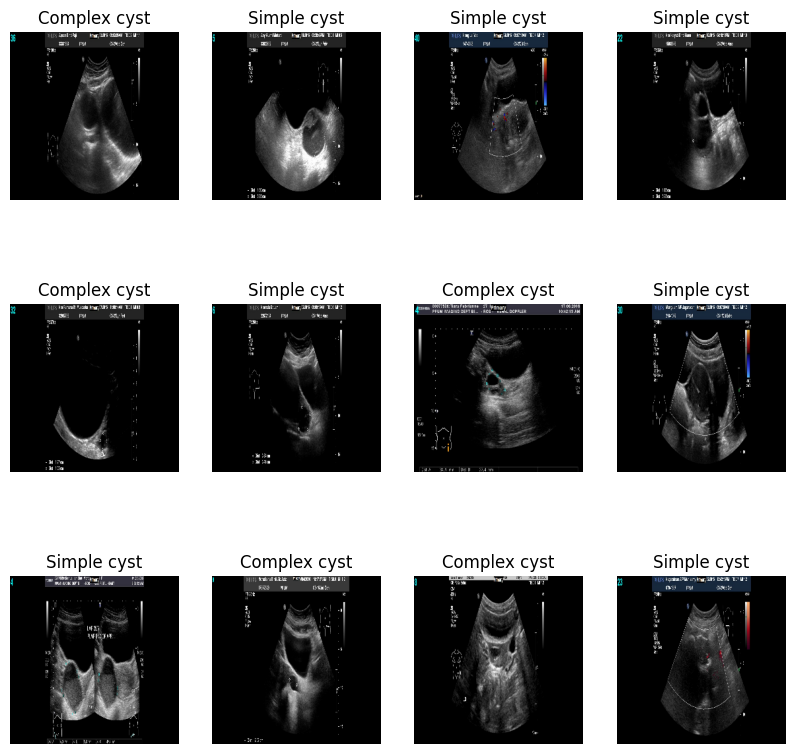

In [ ]:
# Display a batch of images with labels

plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
# Define a function to split the dataset

def get_dataset(ds,train_split=0.6,val_split=0.2,test_split=0.2,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)



    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [ ]:

# Split the dataset into training, validation, and testing sets

train_ds,val_ds,test_ds = get_dataset(dataset)

In [ ]:

# Print the lengths of the datasets

print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))


Length of Training Dataset is 11

Length of Validation Dataset is 3

Length of Testing Dataset is 5


In [ ]:
# Cache, shuffle, and prefetch the datasets for performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Define image resizing and rescaling layers

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),  # Updated import path for Resizing
    tf.keras.layers.Rescaling(1.0/255) # Updated import path for Rescaling
])

In [ ]:

# Define data augmentation layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),# Randomly flip images horizontally and vertically
    layers.RandomRotation(0.3), # Randomly rotate images by up to 0.3 radians
])

In [ ]:
# Define the number of classes and input shape

n_classes = 2 # Number of classes in the dataset
shape = (256, 256, 3)   # Input shape of the model (excluding batch size)


model = models.Sequential([
    layers.InputLayer(shape=shape),  # Define the input shape explicitly
    resize_and_rescale,  # Assume this is a valid preprocessing layer
    data_augmentation,  # Assume this is a valid data augmentation layer
    layers.Conv2D(32, (3, 3), activation='relu'), # Convolutional layer with 32 filters and ReLU activation
    layers.MaxPooling2D((2, 2)), # Max pooling layer with 2x2 pool size
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
    layers.MaxPooling2D((2, 2)),# Max pooling layer with 2x2 pool size
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
# Print the model summary

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,625,986 (113.01 MB)

 Trainable params: 29,625,986 (113.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model

model.compile(
optimizer='adam',  # Use the Adam optimizer
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']  # Track accuracy as a metric
)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model

history = model.fit(
train_ds,  # Training dataset
epochs=100,  # Number of training epochs
batch_size=BATCH_SIZE,
verbose=1, # Print training progress
callbacks=[early_stopping], # Apply early stopping
validation_data=val_ds) # Validation dataset

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.5430 - loss: 1.0096 - val_accuracy: 0.5312 - val_loss: 0.6896
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5135 - loss: 0.6937 - val_accuracy: 0.5312 - val_loss: 0.6919
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5455 - loss: 0.6922 - val_accuracy: 0.5312 - val_loss: 0.6895
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5227 - loss: 0.6910 - val_accuracy: 0.5312 - val_loss: 0.6905
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5539 - loss: 0.6874 - val_accuracy: 0.5312 - val_loss: 0.6910
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5030 - loss: 0.6940 - val_accuracy: 0.5312 - val_loss: 0.6886
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5603 - loss: 0.6905 - val_accuracy: 0.5312 - val_loss: 0.6892
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4943 - loss: 0.6893 - val_accuracy: 

In [ ]:
### Evaluate the model on the test dataset

scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6230 - loss: 0.6113


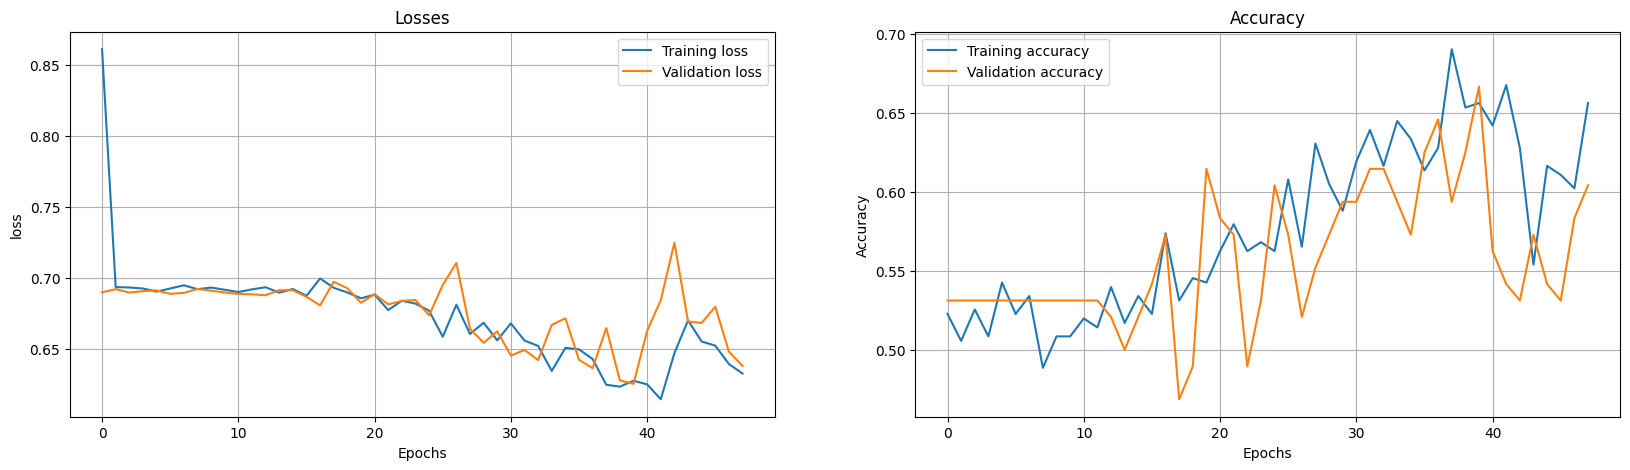

In [ ]:
# Plot the training history

his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

First Image to Predict :

Actual label: Complex cyst
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step

Predicted label Complex cyst


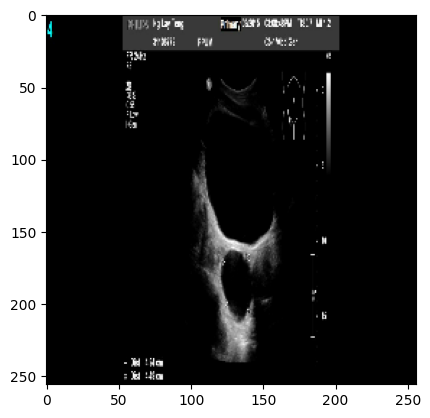

In [ ]:
# Predict on a single image from the test dataset

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Define a prediction function

def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

In [ ]:
# Predict on multiple images from the test dataset and display results

plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:

from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras import layers

# Create the base ResNet50V2 model with pre-trained weights
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the ResNet base model so they are not trained
for layer in resnet_base.layers:
    layer.trainable = False

# Define the number of classes
n_classes = len(class_names)

# Build the new model
model1 = models.Sequential([
    layers.InputLayer(shape=shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.Dropout(0.5), # Consider adding Dropout here
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.Dropout(0.5), # Consider adding Dropout here
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(), # Added Batch Normalization
    layers.Dropout(0.5), # Consider adding Dropout here
    layers.Dense(n_classes, activation='softmax'),
])

# Print the model summary
model1.summary()

# Compile the model
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# Define a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.0001
)

# Train the model
history = model1.fit(
    train_ds,
    epochs=EPOCHES,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler], # Add learning rate scheduler
    validation_data=val_ds
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 29,628,674 (113.02 MB)

 Trainable params: 29,627,330 (113.02 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.4869 - loss: 1.3934 - val_accuracy: 0.5417 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.5082 - loss: 1.4060 - val_accuracy: 0.5312 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4611 - loss: 1.3099 - val_accuracy: 0.5312 - val_loss: 0.7392 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4852 - loss: 1.2944 - val_accuracy: 0.5312 - val_loss: 0.8737 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5184 - loss: 1.1261 - val_accuracy: 0.5312 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.5180 - loss: 1.1355 - val_accuracy: 0.5312 - val_loss: 0.7339 - learning_rate: 5.0000e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4711 - loss

In [ ]:
# Evaluate the model on the test dataset
scores = model1.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5492 - loss: 0.6878


In [ ]:
loss = scores[0]
accuracy = scores[1]

In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.6929
Test Accuracy: 0.5188


In [ ]:
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 51.88%


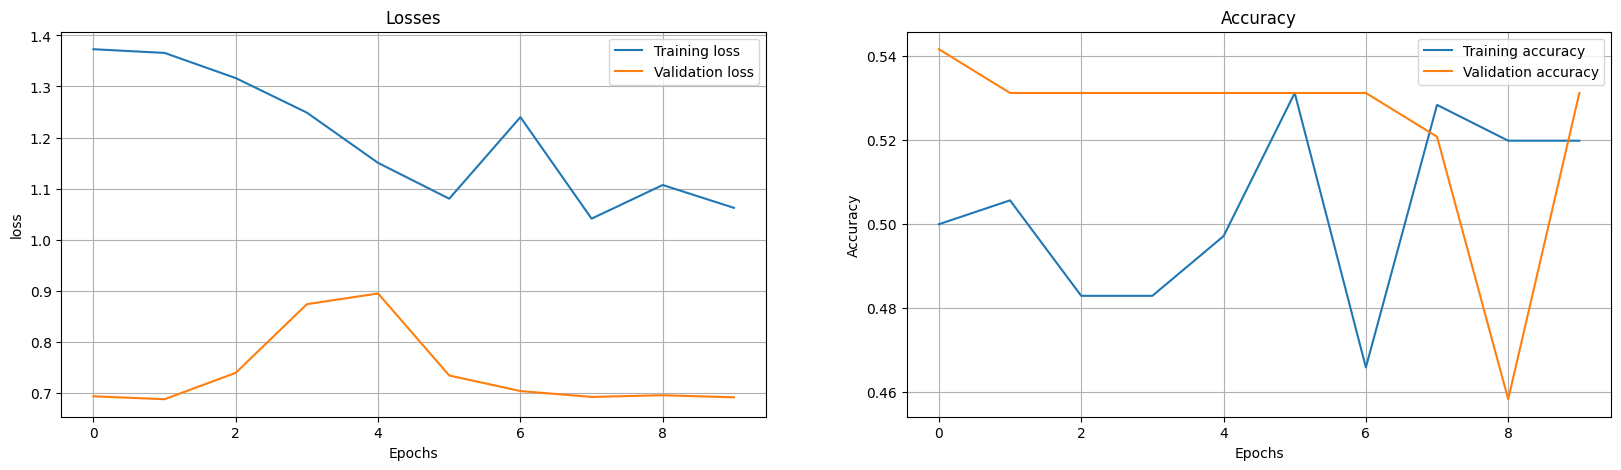

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()


First Image to Predict :

Actual label: Simple cyst
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Predicted label Simple cyst


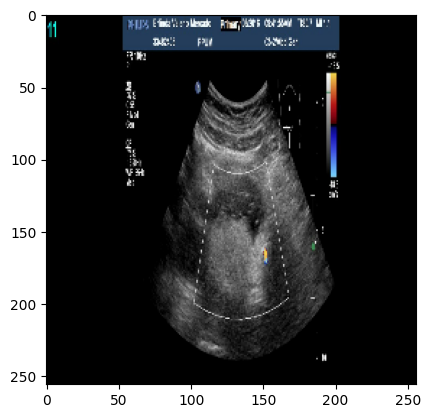

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model1,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model1.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


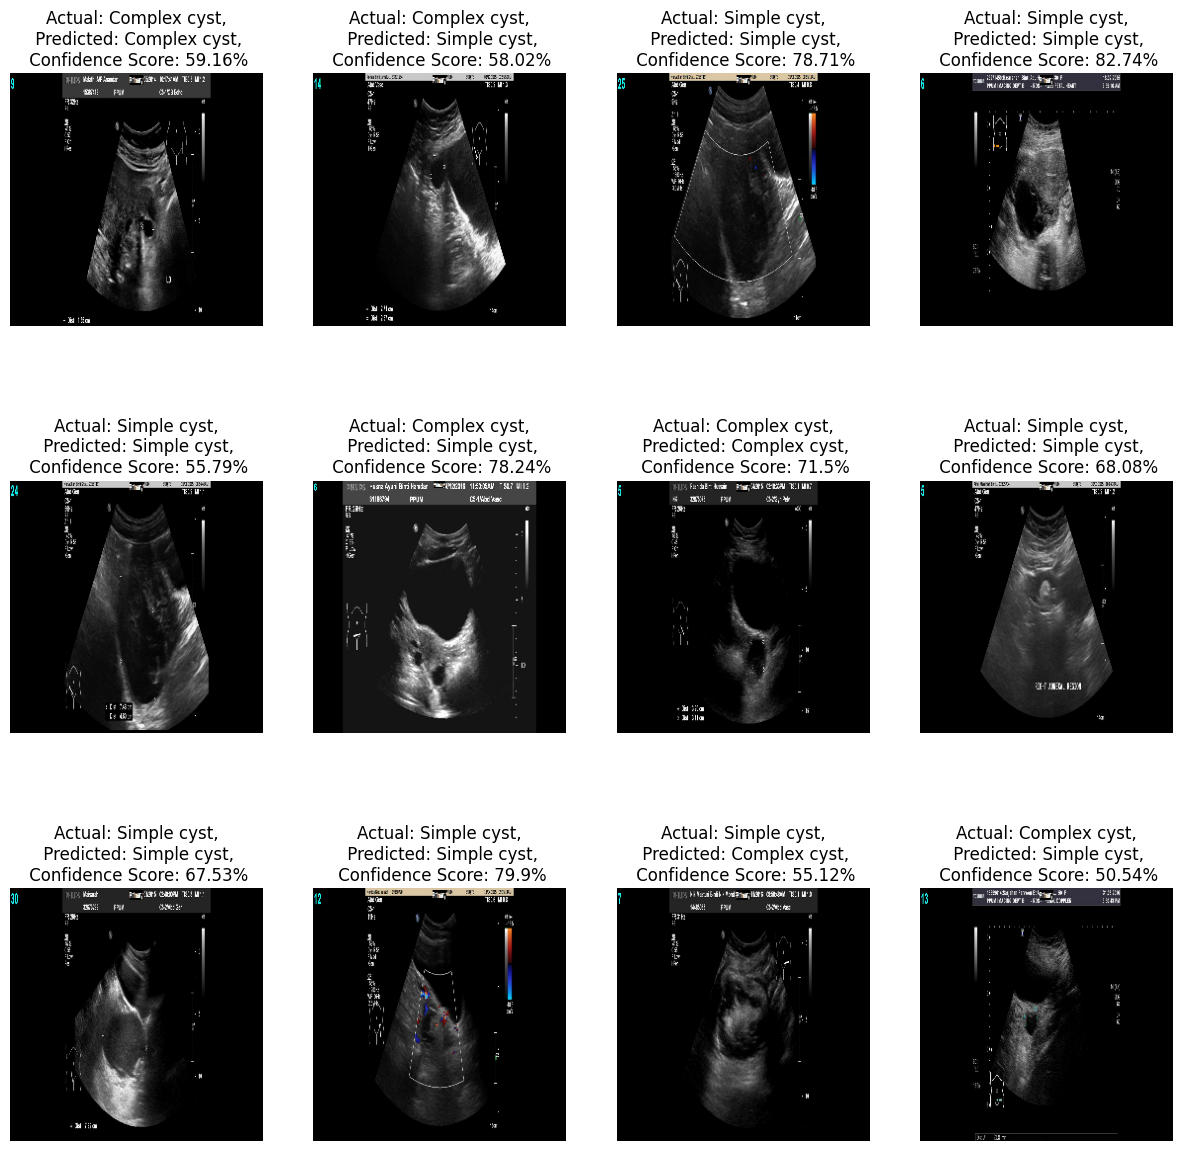

In [ ]:
# Predict on multiple images from the test dataset and display results

plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and input shape
image_size = 256
input_shape = (image_size, image_size, 3)

# Load VGG19 without top layers and with pretrained ImageNet weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model to use its pretrained features
base_model.trainable = False

# Define the Sequential model
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# OPTIONAL: Data augmentation to improve generalization (recommended)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# test_datagen = ImageDataGenerator(rescale=1./255)  # For validation/test

# model.fit(train_generator, validation_data=val_generator, epochs=10)  # example


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential # Add this line at the beginning
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19


# Define image_size
image_size = 256  # Or whatever size you want to use

base_model1 = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

model = Sequential()
model.add(base_model1)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

base_model1.trainable = False

model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,933,697 (140.89 MB)

 Trainable params: 16,909,313 (64.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping],
    epochs=100)  # Adjust epochs as needed

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 530ms/step - accuracy: 0.4062 - loss: 8.5248 - val_accuracy: 0.7083 - val_loss: 1.5131
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.6306 - loss: 4.7875 - val_accuracy: 0.6250 - val_loss: 2.0556
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.5986 - loss: 4.1995 - val_accuracy: 0.7188 - val_loss: 1.1968
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.6518 - loss: 2.8805 - val_accuracy: 0.6875 - val_loss: 1.5832
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.7033 - loss: 2.5782 - val_accuracy: 0.7812 - val_loss: 1.1197
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.7437 - loss: 1.7575 - val_accuracy: 0.7396 - val_loss: 1.1977
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 435ms/step - accuracy: 0.7882 - loss: 1.2172 - val_accuracy: 0.8333 - val_loss: 0.9607
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - accuracy: 0.7941 - loss: 1.0706 - val_acc

In [ ]:
# Evaluate the model on the test dataset
scores = model2.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.8754 - loss: 0.6797


In [ ]:
loss = scores[0]
accuracy = scores[1]

In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.6660
Test Accuracy: 0.8750


In [ ]:
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 87.50%


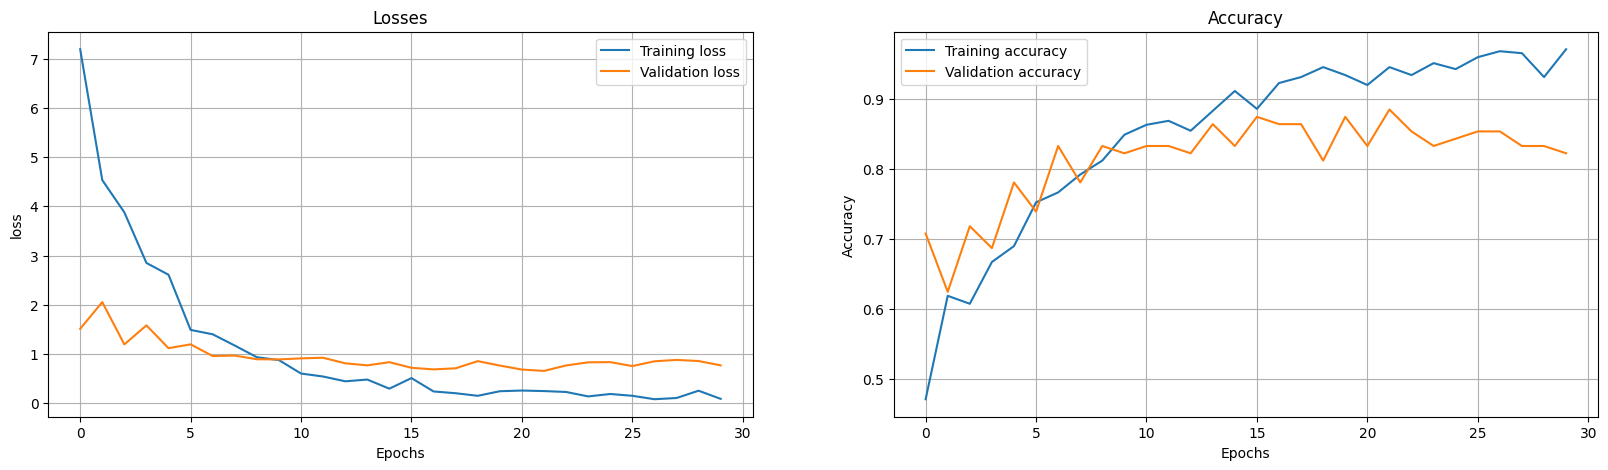

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()


First Image to Predict :

Actual label: Complex cyst
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Predicted label Complex cyst


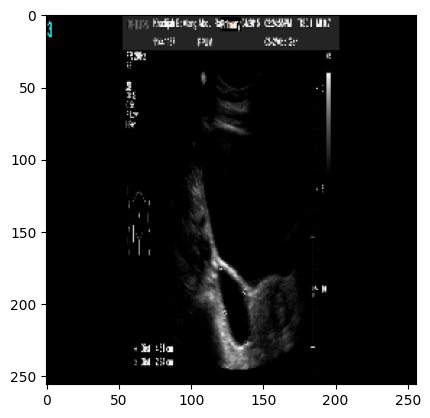

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model2. predict (images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model2,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model2.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


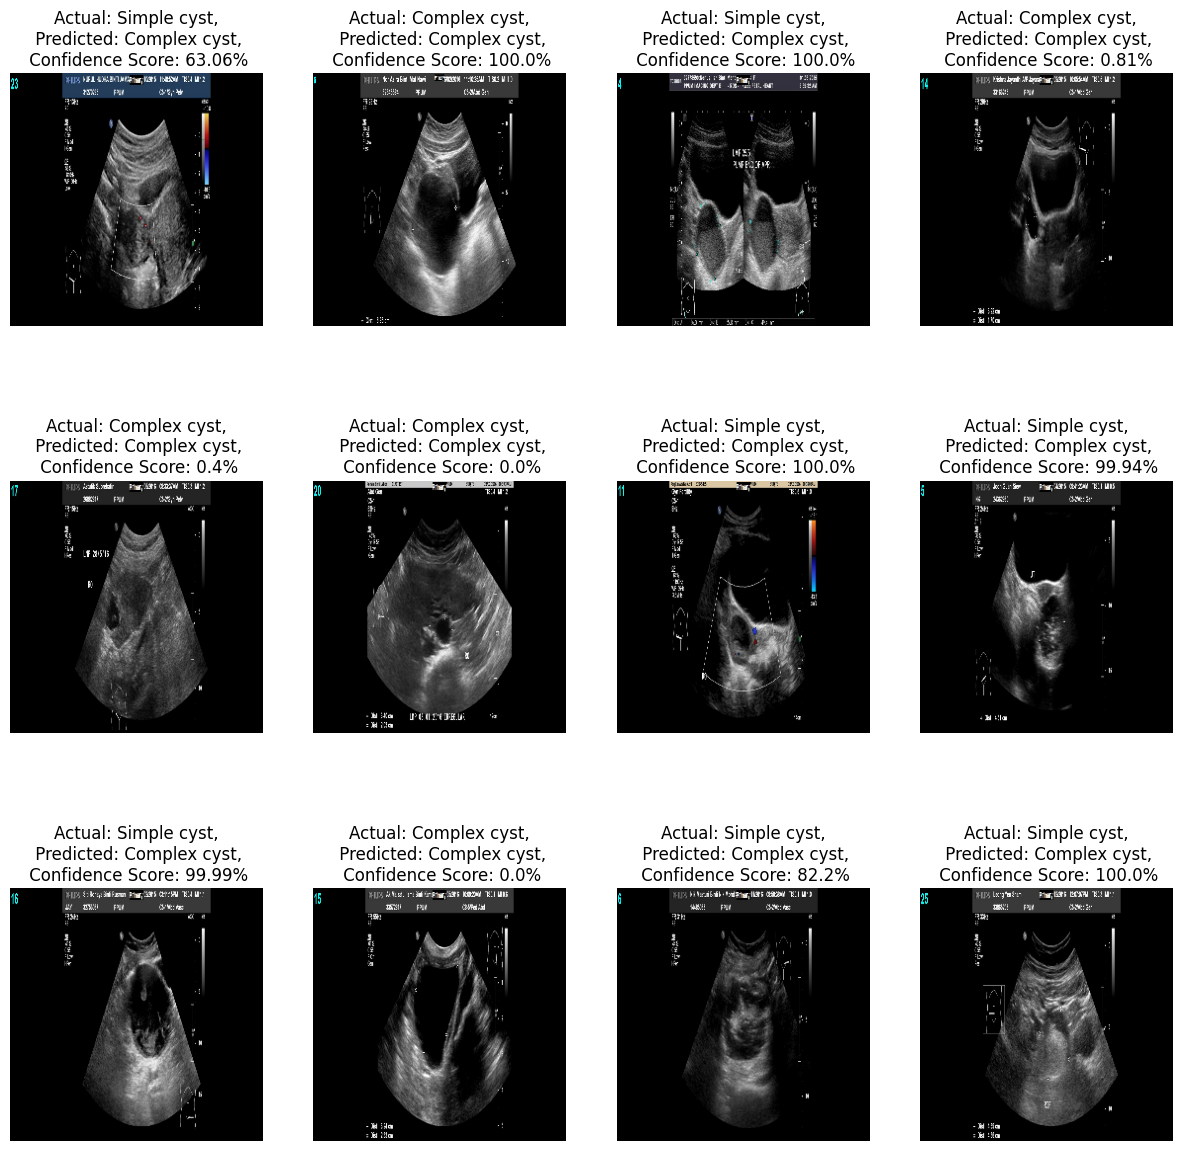

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model2,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
# Define the directory where you want to save the model
save_dir = "/content/drive/MyDrive/saved_models"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the trained model
# Added the .keras extension to the filename for the native Keras format
model2.save(os.path.join(save_dir, 'my_image_cyst_model.keras'))

In [ ]:
# prompt: i need the streamlit to build a webapp that classify it is Simple or complex cyst

!pip install streamlit
!pip install tensorflow

import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the trained model
@st.cache_resource # Cache the model to avoid reloading on every interaction
def load_model():
    # Define the directory where the model is saved
    save_dir = "/content/drive/MyDrive/saved_models"
    # Construct the full path to the saved model file
    model_path = os.path.join(save_dir, 'my_image_cyst_model.keras')
    model = tf.keras.models.load_model(model_path)
    return model

model = load_model()

# Define the class names (make sure this matches the order used during training)
class_names = ['Simple Cyst', 'Complex Cyst'] # Adjust if your class names are different

# Streamlit App
st.title("Cyst Image Classifier")
st.write("Upload an ultrasound image to classify if it is a Simple or Complex Cyst.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Preprocess the image
    img_array = tf.keras.preprocessing.image.img_to_array(image.resize((256, 256))) # Resize to the model's input size
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = img_array / 255.0 # Rescale the image data if your training data was rescaled

    # Make prediction
    predictions = model.predict(img_array)

    # For a sigmoid output layer (binary classification), the output is a single value between 0 and 1.
    # Assuming 0 corresponds to 'Simple Cyst' and 1 corresponds to 'Complex Cyst'.
    # You might need to adjust this based on how your labels were encoded during training.
    if predictions[0][0] >= 0.5:
        predicted_class = 'Complex Cyst'
        confidence = predictions[0][0] * 100
    else:
        predicted_class = 'Simple Cyst'
        confidence = (1 - predictions[0][0]) * 100

    st.write(f"Prediction: {predicted_class}")
    st.write(f"Confidence: {confidence:.2f}%")

# To run this in Colab:
# 1. Save the code above as a Python file (e.g., `app.py`) in your Colab environment.
# 2. Make sure your model file (`my_image_cyst_model.keras`) is accessible in the specified path.
# 3. Run the following in a code cell:
#    !streamlit run app.py & npx localtunnel --port 8501
# 4. Click the generated public URL to access the Streamlit app.
